# Otimização de modelos ML para predição de diabetes - Nuno

## Partes

**- 1 Importação e limpeza dos dados**  

**- 2 EDA**  

**- 3 Otimização de modelos**  

## Origem dos dados
link: https://archive.ics.uci.edu/dataset/529/early+stage+diabetes+risk+prediction+dataset  

This has been collected using direct questionnaires from the patients of Sylhet Diabetes Hospital in Sylhet, Bangladesh and approved by a doctor.

Early stage diabetes risk prediction dataset.. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5VG8H

Dados obtidos em 23 de setembro de 2023.

**Razões para a escolha:**  
- pode ser construído um modelo com dados fáceis de preencher por qualquer pessoa, sem necessidade de exames de sangue ou qualquer procedimento invasivo ou complexo.

**Drawbacks da base de dados:**
- cerca de 500 entradas pode ser pouco para o treino do modelo  
    - no entanto, dados clínicos são difíceis de obter em larga escala
- aparentemente sem citações, apesar de outras DB também arquivas no UCI terem muito mais citações 
- as colunas não acompanhadas de explicações detalhadas sobre os dados contidos nem sobre como os dados foram obtidos
    - os nomes das colunas são em geral auto-explicativos

## 1 Importação e limpeza dos dados

In [101]:
# importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, recall_score, f1_score
import joblib

In [66]:
#importar dados
df = pd.read_csv('datasets/diabetes_data_upload.csv')
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [67]:
#transformar nomes de colunas em snake_case
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


**Algumas das colunas correspondem a alterações que provavelmente os usuários terão dificuldade em saber, e nós queremos um formulário com coisas que todo mundo saiba preencher com facilidade. Vamos escolher quais colunas não usar.**

**Notas sobre cada coluna:**  
- 1 polyuria
    - poliúria
    - urinar mais de 2.5L por dia
- 1 polydipsia
    - polidipsia
    - vontade constante de beber água
- 1 sudden_weight_loss
    - perda de peso repentina
- weakness
    - fraqueza
- 1 polyphagia
    - polifagia
    - vontade de comer superior ao normal
- genital_thrush
    - infeção fúngica genital
- 1 visual_blurring
    - visão turva
- itching
    - comichão
- 1 **irritability
    - irritabilidade
- 1 delayed_healing
    - cicatrização lenta
- partial_paresis
    - paresia parcial
    - movimento limitado ou fraco, pouca força e coordenação em parte do corpo
- muscle_stiffness
    - rigidez muscular
- 1 alopecia
    - alopécia
    - perda de cabelo
- 1 **obesity : precisamos perguntar peso e altura para definir o IMC e depois definir se é obesidade ou não**
    - obesidade

In [68]:
#infos do df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 520 non-null    int64 
 1   gender              520 non-null    object
 2   polyuria            520 non-null    object
 3   polydipsia          520 non-null    object
 4   sudden_weight_loss  520 non-null    object
 5   weakness            520 non-null    object
 6   polyphagia          520 non-null    object
 7   genital_thrush      520 non-null    object
 8   visual_blurring     520 non-null    object
 9   itching             520 non-null    object
 10  irritability        520 non-null    object
 11  delayed_healing     520 non-null    object
 12  partial_paresis     520 non-null    object
 13  muscle_stiffness    520 non-null    object
 14  alopecia            520 non-null    object
 15  obesity             520 non-null    object
 16  class               520 no

Sem dados nulos.

In [69]:
#verificar dados únicos para cada coluna
unique_values = {}
for column in df.columns:
    unique_values[column] = df[column].unique()

#mostrar dados unicos
for column, values in unique_values.items():
    print(f'Unique values in {column}: {values}')

Unique values in age: [40 58 41 45 60 55 57 66 67 70 44 38 35 61 54 43 62 39 48 32 42 52 53 37
 49 63 30 50 46 36 51 59 65 25 47 28 68 56 31 85 90 72 69 79 34 16 33 64
 27 29 26]
Unique values in gender: ['Male' 'Female']
Unique values in polyuria: ['No' 'Yes']
Unique values in polydipsia: ['Yes' 'No']
Unique values in sudden_weight_loss: ['No' 'Yes']
Unique values in weakness: ['Yes' 'No']
Unique values in polyphagia: ['No' 'Yes']
Unique values in genital_thrush: ['No' 'Yes']
Unique values in visual_blurring: ['No' 'Yes']
Unique values in itching: ['Yes' 'No']
Unique values in irritability: ['No' 'Yes']
Unique values in delayed_healing: ['Yes' 'No']
Unique values in partial_paresis: ['No' 'Yes']
Unique values in muscle_stiffness: ['Yes' 'No']
Unique values in alopecia: ['Yes' 'No']
Unique values in obesity: ['Yes' 'No']
Unique values in class: ['Positive' 'Negative']


Todas a colunas apresentam os dados esperados.  
  
Vamos verificar a distribuição de idades.

## 2 EDA

<AxesSubplot:>

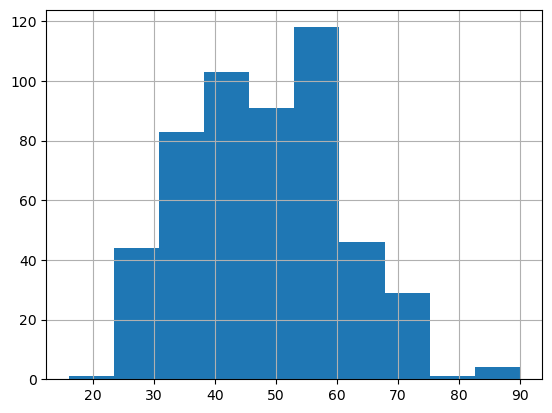

In [70]:
#distribuição de dados
df['age'].hist()

Nada de estranho, com ums distribuição relativamente normal.

**Vamos apagar as colunas em que usuários terão mais dificuldade de preencher com acurácia.(e portanto farão o questionário desnecessariamente tedioso)**

In [71]:
#apagar colunas difíceis de auto-avaliação

del_cols = ['weakness', 'genital_thrush', 'itching', 'partial_paresis', 'muscle_stiffness']
df.drop(columns=del_cols, inplace=True)
df.head()


,age,gender,polyuria,polydipsia,sudden_weight_loss,polyphagia,visual_blurring,irritability,delayed_healing,alopecia,obesity,class
0,40,Male,No,Yes,No,No,No,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,No,Yes,No,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,No,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,No,No,Yes,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 520 non-null    int64 
 1   gender              520 non-null    object
 2   polyuria            520 non-null    object
 3   polydipsia          520 non-null    object
 4   sudden_weight_loss  520 non-null    object
 5   polyphagia          520 non-null    object
 6   visual_blurring     520 non-null    object
 7   irritability        520 non-null    object
 8   delayed_healing     520 non-null    object
 9   alopecia            520 non-null    object
 10  obesity             520 non-null    object
 11  class               520 non-null    object
dtypes: int64(1), object(11)
memory usage: 48.9+ KB


Agora temos 12 colunas ao todo. 11 de features e 1 de target (class). 

In [73]:
#substituir valores de string por logicos 1 e 0
# Yes e Positive são 1. Male é 0 e Female é 1.
df.replace({'Yes': 1, 'No': 0, 'Positive': 1, 'Negative': 0, 'Female': 1, 'Male': 0}, inplace=True)
df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,polyphagia,visual_blurring,irritability,delayed_healing,alopecia,obesity,class
0,40,0,0,1,0,0,0,0,1,1,1,1
1,58,0,0,0,0,0,1,0,0,1,0,1
2,41,0,1,0,0,1,0,0,1,1,0,1
3,45,0,0,0,1,1,0,0,1,0,0,1
4,60,0,1,1,1,1,1,1,1,1,1,1


In [74]:
#ver o balanceamento de classe de class
df['class'].sum()/len(df)

0.6153846153846154

62% de entradas positivas para diabetes (vs 38% negativas)

In [75]:
#verificar imbalanceamento para diferentes colunas
for column in df.columns:
    rel_freq = df[column].sum()/len(df)
    print(f'{column}: \n{rel_freq}\n')

age: 
48.02884615384615

gender: 
0.36923076923076925

polyuria: 
0.49615384615384617

polydipsia: 
0.4480769230769231

sudden_weight_loss: 
0.4173076923076923

polyphagia: 
0.45576923076923076

visual_blurring: 
0.4480769230769231

irritability: 
0.2423076923076923

delayed_healing: 
0.4596153846153846

alopecia: 
0.34423076923076923

obesity: 
0.16923076923076924

class: 
0.6153846153846154



Ignorando 'age', as classes mais desbalanceadas são: gender (com 37% mulheres), irritabilidade (com 24% sim), e obesidade (com 17%).

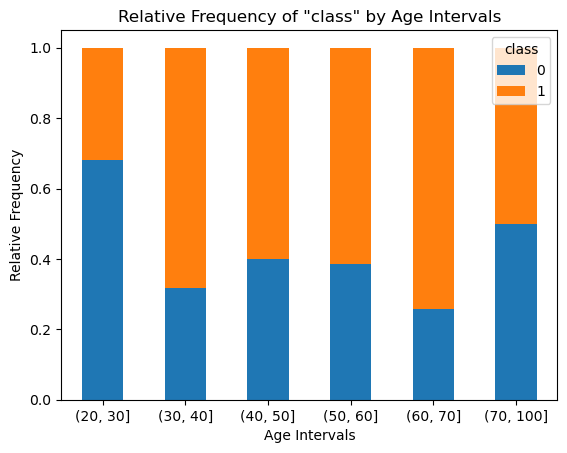

In [76]:
# Define age intervals (bins)
age_bins = [20, 30, 40, 50, 60, 70, 100]

# criar intervalos para idade usando pd.cut
df['age_intervals'] = pd.cut(df['age'], bins=age_bins)

# calcular a frequencia relativa de 'class' dentro de cada intervalo
relative_freq = df.groupby(['age_intervals', 'class']).size().unstack(fill_value=0)
relative_freq = relative_freq.div(relative_freq.sum(axis=1), axis=0)

# Plotar gráfico de barras
ax = relative_freq.plot(kind='bar', stacked=True)
ax.set_ylabel('Relative Frequency')
ax.set_xlabel('Age Intervals')

plt.title('Relative Frequency of "class" by Age Intervals')
plt.xticks(rotation=0)
plt.legend(title='class')
plt.show()

Até aos 30 anos, a frequência de diabetes é menor, mas mantém-se mais ou menos constante com a idade

## 3 Otimização de modelos ML

### Ajuste dos dados e Separação em teste e treino

In [79]:
# dividir em festures e target
X = df.drop(columns = ['class', 'age_intervals'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
#scaling dos dados
#colunas numéricas
numeric = ['age']

#preparaçãoda variável de escalonamento com as colunas numéricas do treino
scaler = StandardScaler()
scaler.fit(X_train[numeric])

#transformação da coluna com scaling
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

**Com os dados prontos, vamos otimizar os modelos.**  
- usaremos bootstrap para evitar viés no fitting dos modelos
- as métricas a usar serão
    - recall: melhor que precisão neste caso porque é preferível sobre-estimar os casos positivos
    - F1: para garantir que não há um exagero da sobre-estimação, então é uma métrica que toma em conta ambos o recall e precisão

### Regressão logística

In [85]:
# Logistic Regression
model = LogisticRegression()

#fazer bootstraping para obter dados mais fidedignos (y_predicted contem as predições de todos os folds)
y_predicted = cross_val_predict(model, X_train, y_train, cv=4)

lr_f1 = f1_score(y_train, y_predicted)
lr_recall = recall_score(y_train, y_predicted)


print('F1 Score on Training Set:', lr_f1)
print('Recall Score on Training Set:', lr_recall)

F1 Score on Training Set: 0.923076923076923
Recall Score on Training Set: 0.9156626506024096


**O modelo com melhor valor de recall é também o de maior F1.**  
 
**Recall:0.923**  
**F1: 0.916**